In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [2]:
file_path = "smart_prosthetic_dataset.csv"
df = pd.read_csv(file_path)

In [3]:
# Convert Timestamp to human-readable format
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit='s')

In [4]:
# Compute new features
df["Accel_Magnitude"] = (df["Accel_X"]**2 + df["Accel_Y"]**2 + df["Accel_Z"]**2)**0.5
df["Gyro_Magnitude"] = (df["Gyro_X"]**2 + df["Gyro_Y"]**2 + df["Gyro_Z"]**2)**0.5

In [5]:
# Function to cap outliers using IQR method
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

In [7]:
# Apply outlier capping
outlier_columns = ["EMG (mV)", "PAM Pressure (kPa)", "Muscle Contraction (%)", "Airflow Rate (L/min)"]
for col in outlier_columns:
    df = cap_outliers(df, col)

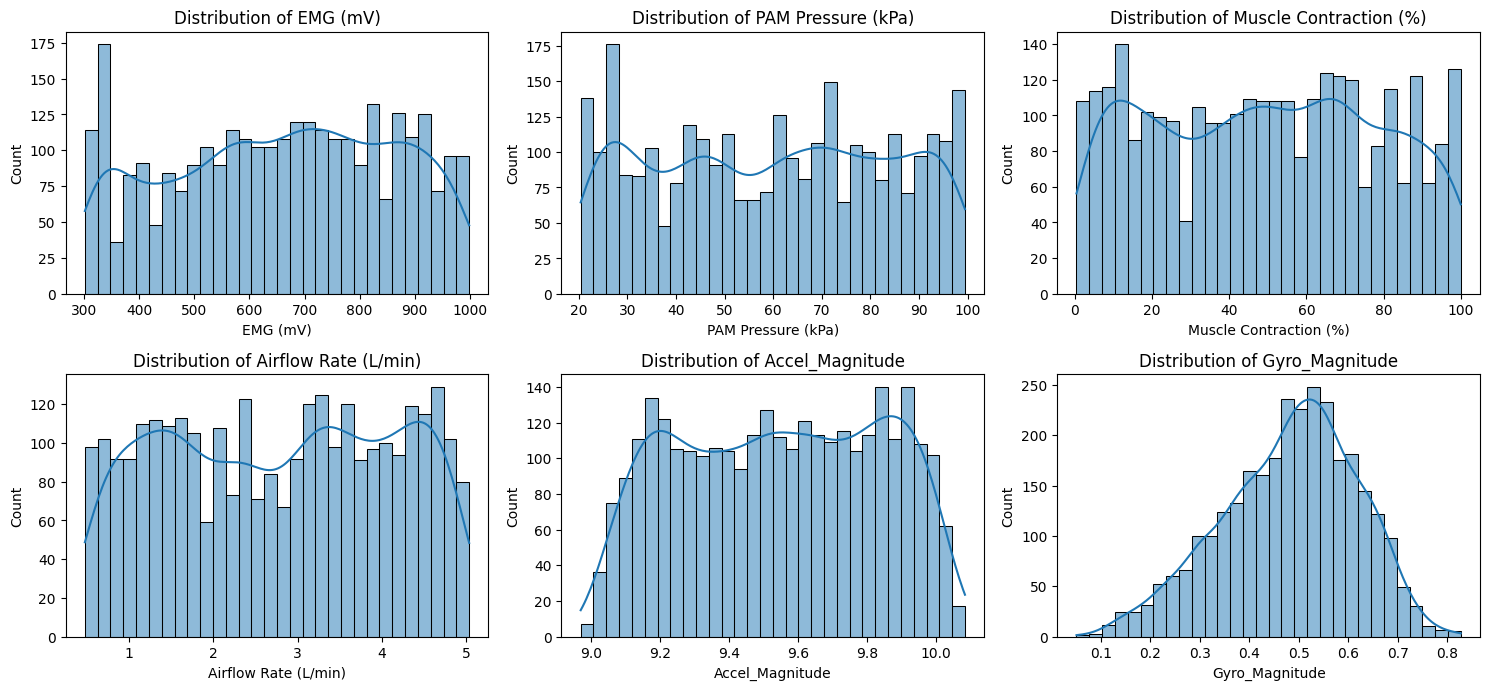

In [8]:
# Plot feature distributions
num_features = ["EMG (mV)", "PAM Pressure (kPa)", "Muscle Contraction (%)", "Airflow Rate (L/min)", "Accel_Magnitude", "Gyro_Magnitude"]
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

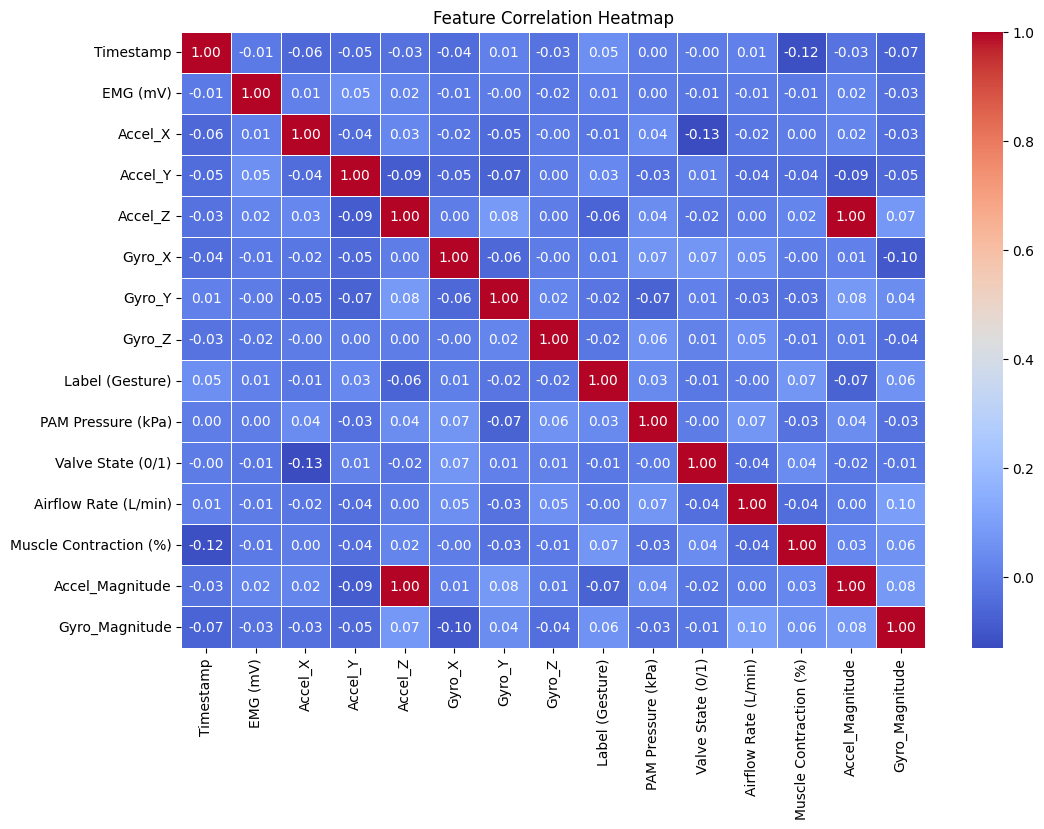

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score  # Import the required metrics

file_path = "smart_prosthetic_dataset.csv"
df = pd.read_csv(file_path)

# Features and target variable
X = df.drop(columns=['Label (Gesture)'])  # Features
y = df['Label (Gesture)']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))  # Now this will work
print("R² Score:", r2_score(y_test, y_pred))  # This will also work

# Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

Mean Squared Error: 0.08520818003035859
R² Score: 0.9591981681230356
                   Feature  Importance
1                 EMG (mV)    0.130276
11  Muscle Contraction (%)    0.125858
8       PAM Pressure (kPa)    0.106142
10    Airflow Rate (L/min)    0.090685
3                  Accel_Y    0.088653
7                   Gyro_Z    0.078740
2                  Accel_X    0.076086
0                Timestamp    0.072616
5                   Gyro_X    0.070395
6                   Gyro_Y    0.069657
4                  Accel_Z    0.068364
9        Valve State (0/1)    0.022527


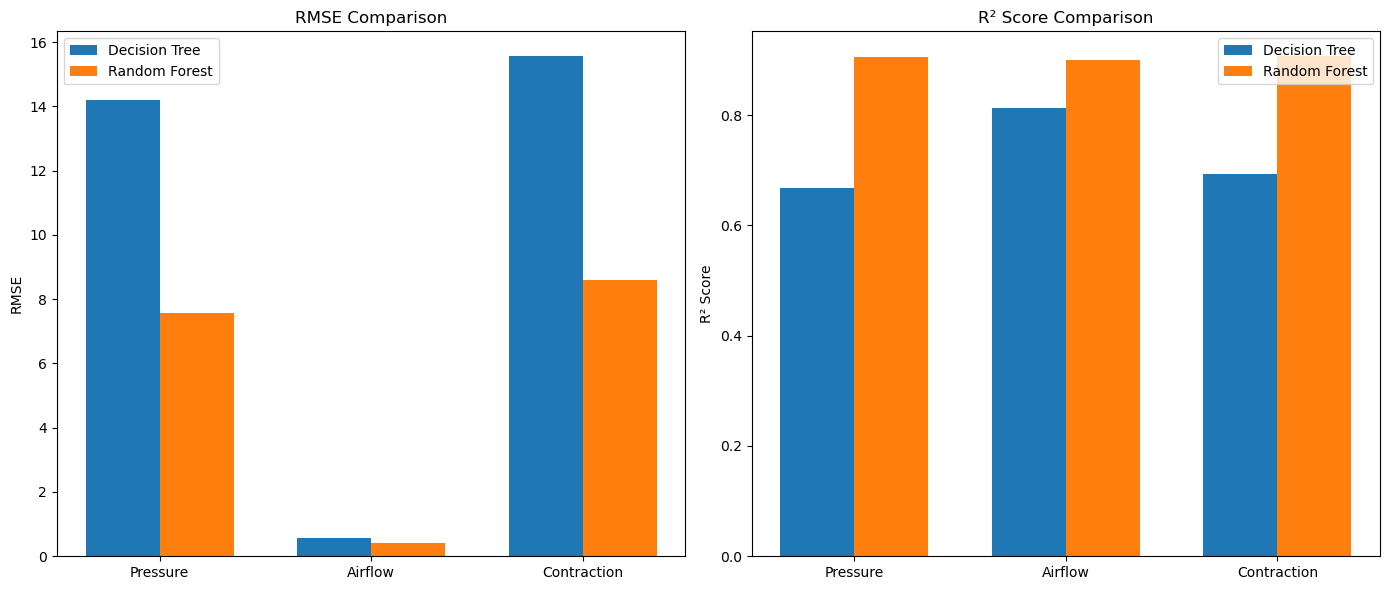

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('smart_prosthetic_dataset.csv')

# Select features and target variables
X = df[['EMG (mV)', 'Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']]
y_pressure = df['PAM Pressure (kPa)']
y_airflow = df['Airflow Rate (L/min)']
y_contraction = df['Muscle Contraction (%)']

# Split data into train and test sets
X_train, X_test, y_p_train, y_p_test = train_test_split(X, y_pressure, test_size=0.2, random_state=42)
_, _, y_a_train, y_a_test = train_test_split(X, y_airflow, test_size=0.2, random_state=42)
_, _, y_c_train, y_c_test = train_test_split(X, y_contraction, test_size=0.2, random_state=42)

# Initialize models
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Evaluate for each target variable
targets = {
    'Pressure': (y_p_train, y_p_test),
    'Airflow': (y_a_train, y_a_test),
    'Contraction': (y_c_train, y_c_test)
}

results = {'Decision Tree': {'RMSE': [], 'R2': []},
           'Random Forest': {'RMSE': [], 'R2': []}}

for name, (y_train, y_test) in targets.items():
    # Decision Tree
    dt_rmse, dt_r2 = evaluate_model(dt, X_train, X_test, y_train, y_test)
    results['Decision Tree']['RMSE'].append(dt_rmse)
    results['Decision Tree']['R2'].append(dt_r2)
    
    # Random Forest
    rf_rmse, rf_r2 = evaluate_model(rf, X_train, X_test, y_train, y_test)
    results['Random Forest']['RMSE'].append(rf_rmse)
    results['Random Forest']['R2'].append(rf_r2)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# RMSE Plot
x = np.arange(len(targets))
width = 0.35
ax1.bar(x - width/2, results['Decision Tree']['RMSE'], width, label='Decision Tree')
ax1.bar(x + width/2, results['Random Forest']['RMSE'], width, label='Random Forest')
ax1.set_xticks(x)
ax1.set_xticklabels(targets.keys())
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Comparison')
ax1.legend()

# R² Plot
ax2.bar(x - width/2, results['Decision Tree']['R2'], width, label='Decision Tree')
ax2.bar(x + width/2, results['Random Forest']['R2'], width, label='Random Forest')
ax2.set_xticks(x)
ax2.set_xticklabels(targets.keys())
ax2.set_ylabel('R² Score')
ax2.set_title('R² Score Comparison')
ax2.legend()

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
from IPython.display import display

# Load the dataset
file_path = "smart_prosthetic_dataset.csv"
df = pd.read_csv(file_path)

# Create a DataFrame with a single column for column names
columns_df = pd.DataFrame(df.columns, columns=["Column Names"])

# Display the table visually in the notebook
display(columns_df)

,Column Names
0,Timestamp
1,EMG (mV)
2,Accel_X
3,Accel_Y
4,Accel_Z
5,Gyro_X
6,Gyro_Y
7,Gyro_Z
8,Label (Gesture)
9,PAM Pressure (kPa)
